# Air Quality and Health Impact Analysis

This Jupyter Notebook provides a comprehensive workflow for analyzing the relationship between air quality metrics and health impact scores. The steps involved in this analysis are as follows:

1. **Import Libraries**: Import necessary libraries for data manipulation, visualization, and analysis.
2. **Load Data**: Load the dataset containing air quality and health impact metrics.
3. **Inspect Data**: Inspect the dataset for missing values, data types, and summary statistics.
4. **Clean Data**: Clean the dataset by handling missing values, converting data types, and removing duplicates.
5. **Validate Data**: Validate the dataset by ensuring all values are within acceptable ranges.
6. **Rename Columns**: Rename columns for better readability and understanding.
7. **Remove Outliers**: Remove outliers using the Interquartile Range (IQR) method.
8. **Save Cleaned Data**: Save the cleaned dataset for future use.
9. **Load Cleaned Data**: Load the cleaned dataset.
10. **Scale Numeric Features**: Scale numeric features for better performance in machine learning algorithms.
11. **Perform PCA**: Perform Principal Component Analysis (PCA) to reduce dimensionality and visualize the data.
12. **Create PCA Biplot**: Create a PCA biplot to visualize the principal components and feature contributions.
13. **Visualize Data**: Create various visualizations to explore the relationships between air quality metrics and health impact scores.

This workflow ensures a thorough analysis of the dataset, providing insights into how air quality affects health outcomes.

In [1]:
# Block 1: import Libraries

import pandas as pd
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from scipy.stats import shapiro

from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV, LassoCV, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.svm import SVR
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score, explained_variance_score,
    mean_absolute_percentage_error, mean_squared_log_error
)


In [2]:
# Block 2: Load Data
df = pd.read_csv('data.csv')

In [3]:
# Block 3: Inspect Data
def inspect_data(df):
    missing_values = df.isnull().sum()
    print("Missing values:\n", missing_values)
    data_types = df.dtypes
    print("\nData types:\n", data_types)
    summary_stats = df.describe()
    print("\nStatistical summary:\n", summary_stats)
    duplicates = df.duplicated().sum()
    print("\nDuplicate rows:", duplicates)
    average = df.mean()
    print("\nAverage:\n", average)
    

inspect_data(df)

Missing values:
 RecordID               0
AQI                    0
PM10                   0
PM2_5                  0
NO2                    0
SO2                    0
O3                     0
Temperature            0
Humidity               0
WindSpeed              0
RC                     0
CardiovascularCases    0
HospitalAdmissions     0
HealthImpactScore      0
HealthImpactClass      0
dtype: int64

Data types:
 RecordID                 int64
AQI                    float64
PM10                   float64
PM2_5                  float64
NO2                    float64
SO2                    float64
O3                     float64
Temperature            float64
Humidity               float64
WindSpeed              float64
RC                       int64
CardiovascularCases      int64
HospitalAdmissions       int64
HealthImpactScore      float64
HealthImpactClass      float64
dtype: object

Statistical summary:
           RecordID          AQI         PM10        PM2_5          NO2  \
count

In [4]:
# Block 4: Clean Data
def clean_data(df):
    df.fillna(df.median(), inplace=True)
    df['Temperature'] = pd.to_numeric(df['Temperature'], errors='coerce')
    df['WindSpeed'] = pd.to_numeric(df['WindSpeed'], errors='coerce')
    df['Humidity'] = pd.to_numeric(df['Humidity'], errors='coerce')
    df['PM10'] = pd.to_numeric(df['PM10'], errors='coerce')
    df['PM2_5'] = pd.to_numeric(df['PM2_5'], errors='coerce')
    df['NO2'] = pd.to_numeric(df['NO2'], errors='coerce')
    df['SO2'] = pd.to_numeric(df['SO2'], errors='coerce')
    df['O3'] = pd.to_numeric(df['O3'], errors='coerce')
    df['RC'] = pd.to_numeric(df['RC'], errors='coerce')
    df['CardiovascularCases'] = pd.to_numeric(df['CardiovascularCases'], errors='coerce')
    df['HospitalAdmissions'] = pd.to_numeric(df['HospitalAdmissions'], errors='coerce')
    df['HealthImpactScore'] = pd.to_numeric(df['HealthImpactScore'], errors='coerce')
    df['AQI'] = pd.to_numeric(df['AQI'], errors='coerce')
    df.drop_duplicates(inplace=True)
    return df

df = clean_data(df)

In [5]:
# Block 5: Validate Data
def validate_data(df):
    columns_to_validate = [
        'WindSpeed', 'Humidity', 'Temperature', 'PM10', 'PM2_5',
        'NO2', 'SO2', 'O3', 'RC', 'CardiovascularCases',
        'HospitalAdmissions', 'HealthImpactScore', 'AQI'
    ]
    
    for column in columns_to_validate:
        median_value = df[column].median()
        if column == 'Temperature':
            df.loc[df[column] < -20, column] = median_value
        else:
            df.loc[df[column] < 0, column] = median_value

    return df

df = validate_data(df)

In [6]:
# Block 6: Rename Columns
def rename_columns(df):
    df.rename(columns={
        'RecordID': 'Record ID',
        'AQI': 'Air Quality Index (AQI)',
        'PM10': 'PM10 (??g/m??) - Particulate Matter <10??m',
        'PM2_5': 'PM2.5 (??g/m??) - Particulate Matter <2.5??m',
        'NO2': 'NO2 (ppb) - Nitrogen Dioxide',
        'SO2': 'SO2 (ppb) - Sulfur Dioxide',
        'O3': 'O3 (ppb) - Ozone',
        'Temperature': 'Temperature (??C)',
        'Humidity': 'Humidity (%)',
        'WindSpeed': 'Wind Speed (m/s)',
        'RC': 'Respiratory Cases',
        'CardiovascularCases': 'Cardiovascular Cases',
        'HospitalAdmissions': 'Hospital Admissions',
        'HealthImpactScore': 'Health Impact Score (0-100)',
        'HealthImpactClass': 'Health Impact Class (0-4)'
    }, inplace=True)
    return df

df = rename_columns(df)

In [7]:
# Block 7: Remove Outliers
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

columns_to_check = ['Respiratory Cases', 'Cardiovascular Cases', 'Hospital Admissions', 'Health Impact Score (0-100)']
for col in columns_to_check:
    df = remove_outliers_iqr(df, col)

In [8]:
# Block 8: Save Cleaned Data
def save_cleaned_data(df):
    df.to_csv('cleaned_data.csv', index=False)

save_cleaned_data(df)

print("\nData cleaning is complete. Cleaned data saved as 'cleaned_data.csv'.")


Data cleaning is complete. Cleaned data saved as 'cleaned_data.csv'.


In [9]:
# Load your dataset
df = pd.read_csv('cleaned_data.csv')  # Replace with your file path

In [10]:
# Data Preparation
X = df.drop(columns=['Record ID', 'Respiratory Cases', 'Health Impact Class (0-4)', 'Cardiovascular Cases', 'Hospital Admissions'])  # Drop irrelevant columns
y = df['Respiratory Cases']

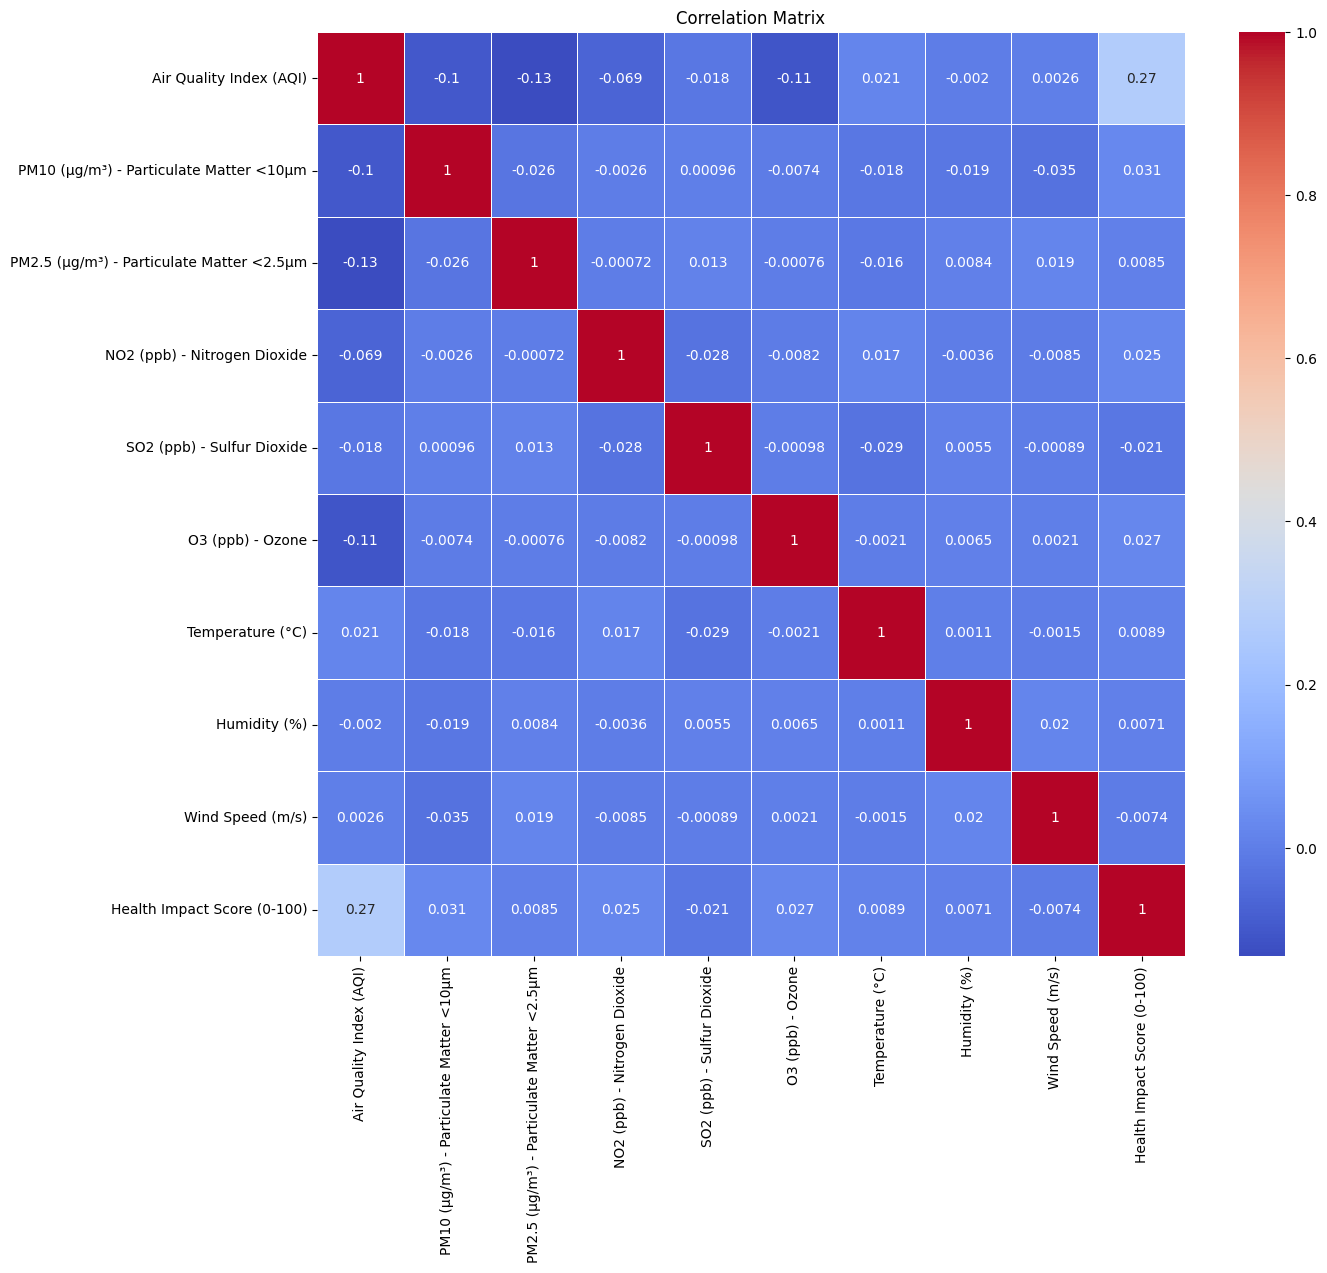

Highly correlated features to remove: set()


In [11]:
# Step 1: Correlation Analysis
def plot_correlation_matrix(df):
    corr_matrix = df.corr()
    plt.figure(figsize=(14, 12))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title('Correlation Matrix')
    plt.show()

    # Identify correlated features
    correlated_features = set()
    threshold = 0.8
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                colname = corr_matrix.columns[i]
                correlated_features.add(colname)
    return correlated_features

correlated_features = plot_correlation_matrix(X)
print(f"Highly correlated features to remove: {correlated_features}")
X = X.drop(columns=correlated_features)

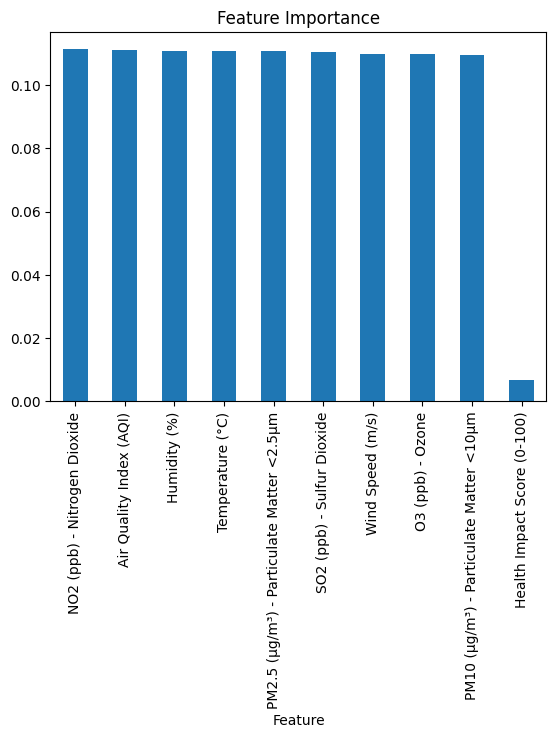

                                     Feature  Importance
3               NO2 (ppb) - Nitrogen Dioxide    0.111184
0                    Air Quality Index (AQI)    0.111173
7                               Humidity (%)    0.110678
6                           Temperature (??C)    0.110614
2  PM2.5 (??g/m??) - Particulate Matter <2.5??m    0.110576
4                 SO2 (ppb) - Sulfur Dioxide    0.110280
8                           Wind Speed (m/s)    0.109764
5                           O3 (ppb) - Ozone    0.109637
1    PM10 (??g/m??) - Particulate Matter <10??m    0.109455
9                Health Impact Score (0-100)    0.006639


In [12]:
# Step 2: Feature Importance Using Random Forest
def feature_importance_random_forest(X, y):
    model = RandomForestClassifier(random_state=42)
    model.fit(X, y)
    importances = model.feature_importances_
    feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    # Plot the importances
    feature_importance_df.plot(kind='bar', x='Feature', y='Importance', legend=False)
    plt.title('Feature Importance')
    plt.show()
    return feature_importance_df

important_features = feature_importance_random_forest(X, y)
print(important_features)

In [13]:
# Step 3: Recursive Feature Elimination (RFE)
def recursive_feature_elimination(X, y, num_features=5):
    model = RandomForestClassifier(random_state=42)
    rfe = RFE(model, n_features_to_select=num_features)
    rfe.fit(X, y)
    selected_features = X.columns[rfe.support_]
    print(f"Selected features by RFE: {selected_features.tolist()}")
    return selected_features

selected_features_rfe = recursive_feature_elimination(X, y, num_features=5)
X = X[selected_features_rfe]  # Keep only the selected features

Selected features by RFE: ['Air Quality Index (AQI)', 'PM10 (??g/m??) - Particulate Matter <10??m', 'O3 (ppb) - Ozone', 'Temperature (??C)', 'Humidity (%)']


In [14]:
# Step 4: Cross-Validation and Model Evaluation
model = RandomForestClassifier(random_state=42)
scores = cross_val_score(model, X, y, cv=6)
print(f"Cross-validation scores: {scores}")
print(f"Mean cross-validation score: {scores.mean()}")

Cross-validation scores: [0.10743802 0.11294766 0.11707989 0.08677686 0.11586207 0.12551724]
Mean cross-validation score: 0.11093695576454198


In [15]:

# Loop through each column in the DataFrame
for column in df.columns:
    stat, p = shapiro(df[column].dropna())  # Using dropna() to handle any NaN values
    #print(f"Column '{column}': p-value = {p}")
    if p > 0.05:
        print(f"Column '{column}': Data looks normally distributed")
    else:
        print(f"Column '{column}': Data is not normally distributed")


Column 'Record ID': Data is not normally distributed
Column 'Air Quality Index (AQI)': Data is not normally distributed
Column 'PM10 (??g/m??) - Particulate Matter <10??m': Data is not normally distributed
Column 'PM2.5 (??g/m??) - Particulate Matter <2.5??m': Data is not normally distributed
Column 'NO2 (ppb) - Nitrogen Dioxide': Data is not normally distributed
Column 'SO2 (ppb) - Sulfur Dioxide': Data is not normally distributed
Column 'O3 (ppb) - Ozone': Data is not normally distributed
Column 'Temperature (??C)': Data is not normally distributed
Column 'Humidity (%)': Data is not normally distributed
Column 'Wind Speed (m/s)': Data is not normally distributed
Column 'Respiratory Cases': Data is not normally distributed
Column 'Cardiovascular Cases': Data is not normally distributed
Column 'Hospital Admissions': Data is not normally distributed
Column 'Health Impact Score (0-100)': Data is not normally distributed
Column 'Health Impact Class (0-4)': Data is not normally distributed

Log Transformation: If your data is highly skewed and contains large outliers (e.g., pollution levels), log transformation (like np.log1p()) can make the distribution more symmetric and improve the performance of models that assume normality.

In [16]:
#Log Transformation
for column in df.columns:
    if pd.api.types.is_numeric_dtype(df[column]):
        df[column] = np.log1p(df[column])


d:\ESPRIT\3AI\DataWarehouse\ML\New folder\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


If skewed or not normal: Consider Min-Max Scaling or Robust Scaling.

In [17]:

#Min-Max Scaling normalization
scaler = MinMaxScaler()

for column in df.columns:
    if pd.api.types.is_numeric_dtype(df[column]):
        df[column] = scaler.fit_transform(df[[column]])


Explained Variance Ratio: [0.14869814 0.14180177 0.1235159  0.0771858  0.06310908 0.06236098
 0.06039374 0.05669116 0.05489837 0.05375677 0.0515938  0.03220622
 0.02934591 0.0292606  0.01518175]
Cumulative Explained Variance: [0.14869814 0.29049991 0.41401581 0.49120162 0.55431069 0.61667168
 0.67706541 0.73375658 0.78865495 0.84241171 0.89400552 0.92621173
 0.95555765 0.98481825 1.        ]


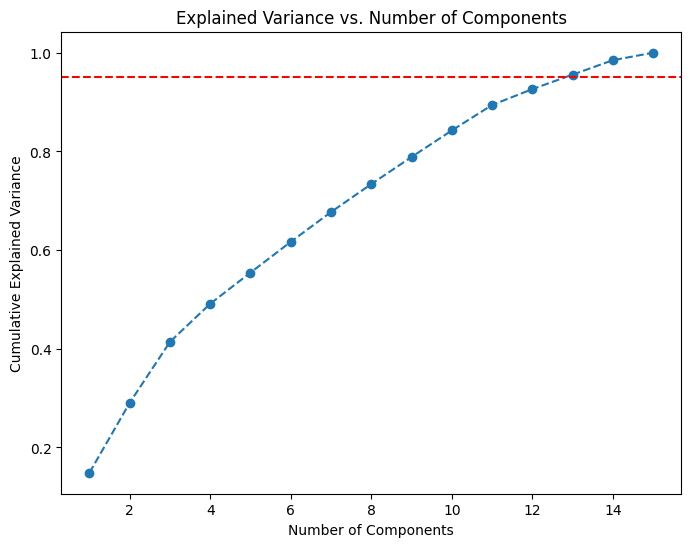

Number of components to capture at least 95% variance: 13


In [18]:



# Step 1: Identify numeric columns
numeric_columns = []
for column in df.columns:
    if pd.api.types.is_numeric_dtype(df[column]):
        numeric_columns.append(column)

# Step 2: Handle missing values by imputing with the mean of each column (if any)
imputer = SimpleImputer(strategy='mean')
df_scaled_imputed = imputer.fit_transform(df[numeric_columns])

# Step 3: Fit PCA to the imputed, scaled data
pca = PCA()
pca.fit(df_scaled_imputed)

# Step 4: Get the explained variance ratio and cumulative variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Output the results
print("Explained Variance Ratio:", explained_variance_ratio)
print("Cumulative Explained Variance:", cumulative_variance)

# Plot to assess the number of components visually
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.axhline(y=0.95, color='r', linestyle='--')  # 95% variance threshold
plt.show()


n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Number of components to capture at least 95% variance: {n_components_95}")


In [19]:
# Use the PCA transformation to reduce the data to 9 components
pca = PCA(n_components=9)
df_pca = pca.fit_transform(df_scaled_imputed)  # Apply to your numeric columns

# Convert the result to a DataFrame for easier handling
df_pca_df = pd.DataFrame(df_pca, columns=[f'PC{i+1}' for i in range(9)])


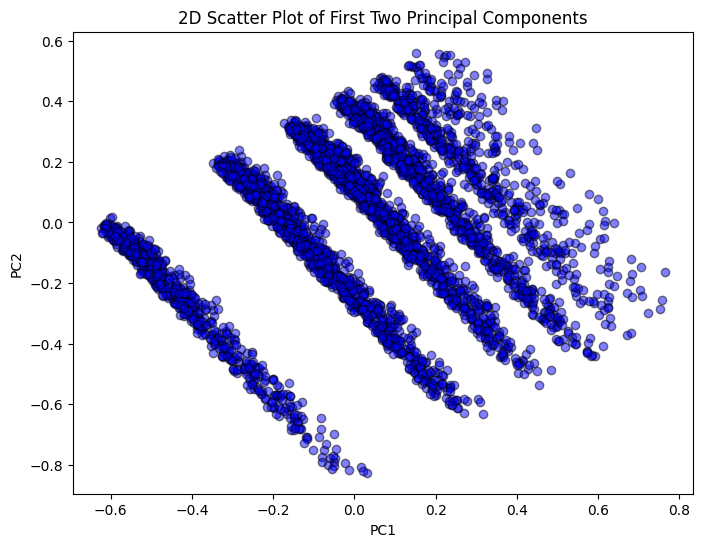

In [20]:

# 2D Scatter plot of the first two principal components
plt.figure(figsize=(8, 6))
plt.scatter(df_pca_df['PC1'], df_pca_df['PC2'], c='blue', edgecolor='k', alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('2D Scatter Plot of First Two Principal Components')
plt.show()


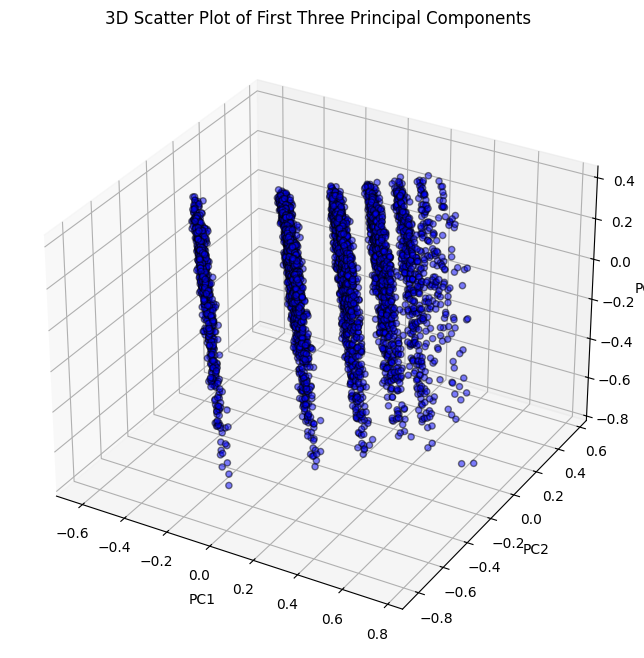

In [21]:


# 3D Scatter plot of the first three principal components
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df_pca_df['PC1'], df_pca_df['PC2'], df_pca_df['PC3'], c='blue', edgecolor='k', alpha=0.5)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D Scatter Plot of First Three Principal Components')

plt.show()


# Training Agorithm selection


In [22]:
# Split data into training and testing sets
print("Selected features:", X.columns)
print("Target : ", y.name)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Selected features: Index(['Air Quality Index (AQI)', 'PM10 (??g/m??) - Particulate Matter <10??m',
       'O3 (ppb) - Ozone', 'Temperature (??C)', 'Humidity (%)'],
      dtype='object')
Target :  Respiratory Cases


In [23]:
# Define models to test
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": RidgeCV(alphas=np.logspace(-6, 6, 13), store_cv_values=True),  # Alpha range from 10^-6 to 10^6
    "Lasso Regression": LassoCV(alphas=np.logspace(-6, 6, 13), cv=5),  # Alpha range with cross-validation (default cv=5)
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Support Vector Regressor": SVR(kernel='rbf'),
    "Random Forest" : RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting Regressor" : GradientBoostingRegressor(n_estimators=100, random_state=42),
    "Neural Network Regressor" : MLPRegressor(random_state=42),
    "K-Nearest Neighbors Regressor" : KNeighborsRegressor(n_neighbors=5),
}

In [24]:
# Evaluate models
results = {}
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    msle = mean_squared_log_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    explained_variance = explained_variance_score(y_test, y_pred)
    
    results[name] = {
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "MAPE": mape,
        "MSLE": msle,
        "R??": r2,
        "Explained Variance": explained_variance
    }
    
    # Print metrics for each model
    print(f"{name}: MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.4f}, "
          f"MSLE: {msle:.4f}, R??: {r2:.4f}, Explained Variance: {explained_variance:.4f}")
    
    # Print chosen alpha for RidgeCV and LassoCV
    if name == "Ridge Regression":
        print(f"Chosen alpha for Ridge: {model.alpha_:.6f}")
    elif name == "Lasso Regression":
        print(f"Chosen alpha for Lasso: {model.alpha_:.6f}")

Training Linear Regression...
Linear Regression: MSE: 9.4650, RMSE: 3.0765, MAE: 2.4517, MAPE: 0.2992, MSLE: 0.0921, R??: -0.0035, Explained Variance: -0.0026
Training Ridge Regression...
Ridge Regression: MSE: 9.4580, RMSE: 3.0754, MAE: 2.4505, MAPE: 0.2991, MSLE: 0.0921, R??: -0.0028, Explained Variance: -0.0019
Chosen alpha for Ridge: 1000000.000000
Training Lasso Regression...
Lasso Regression: MSE: 9.4400, RMSE: 3.0725, MAE: 2.4488, MAPE: 0.2989, MSLE: 0.0919, R??: -0.0009, Explained Variance: 0.0000
Chosen alpha for Lasso: 1000000.000000
Training Random Forest...


d:\ESPRIT\3AI\DataWarehouse\ML\New folder\.venv\Lib\site-packages\sklearn\linear_model\_ridge.py:2341: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(


Random Forest: MSE: 9.9118, RMSE: 3.1483, MAE: 2.5478, MAPE: 0.3096, MSLE: 0.0959, R??: -0.0509, Explained Variance: -0.0508
Training Support Vector Regressor...
Support Vector Regressor: MSE: 9.4813, RMSE: 3.0792, MAE: 2.4557, MAPE: 0.2981, MSLE: 0.0918, R??: -0.0053, Explained Variance: -0.0035
Training Gradient Boosting Regressor...
Gradient Boosting Regressor: MSE: 9.6881, RMSE: 3.1126, MAE: 2.4930, MAPE: 0.3034, MSLE: 0.0939, R??: -0.0272, Explained Variance: -0.0267
Training Neural Network Regressor...
Neural Network Regressor: MSE: 11.1962, RMSE: 3.3461, MAE: 2.6940, MAPE: 0.3225, MSLE: 0.1070, R??: -0.1871, Explained Variance: -0.1835
Training K-Nearest Neighbors Regressor...
K-Nearest Neighbors Regressor: MSE: 11.3593, RMSE: 3.3704, MAE: 2.7029, MAPE: 0.3247, MSLE: 0.1077, R??: -0.2044, Explained Variance: -0.2044


d:\ESPRIT\3AI\DataWarehouse\ML\New folder\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [25]:
# Determine the best model for each metric
best_models = {metric: None for metric in results[next(iter(results))].keys()}
for metric in best_models.keys():
    if metric in ["MSE", "RMSE", "MAE", "MAPE", "MSLE"]:  # Minimize these
        best_models[metric] = min(results, key=lambda x: results[x][metric])
    else:  # Maximize these
        best_models[metric] = max(results, key=lambda x: results[x][metric])

In [26]:
# Count how many times each model was the best for each metric
best_model_count = {model: 0 for model in models}
for metric, model_name in best_models.items():
    best_model_count[model_name] += 1

In [27]:
# Print best models for each metric
print("\nBest Models by Metric:")
for metric, model_name in best_models.items():
    print(f"{metric}: {model_name} - Value: {results[model_name][metric]:.4f}")


Best Models by Metric:
MSE: Lasso Regression - Value: 9.4400
RMSE: Lasso Regression - Value: 3.0725
MAE: Lasso Regression - Value: 2.4488
MAPE: Support Vector Regressor - Value: 0.2981
MSLE: Support Vector Regressor - Value: 0.0918
R??: Lasso Regression - Value: -0.0009
Explained Variance: Lasso Regression - Value: 0.0000


In [28]:
# Print the most chosen model by the metrics
most_chosen_model = max(best_model_count, key=best_model_count.get)
print(f"\nMost Chosen Model by Metrics: {most_chosen_model} with {best_model_count[most_chosen_model]} metrics")



Most Chosen Model by Metrics: Lasso Regression with 5 metrics


In [29]:

model = LassoCV(alphas=np.logspace(-6, 6, 13), cv=5)  # Lasso Regression with cross-validation
model.fit(X_train, y_train)


# Save the model to a file
with open('trained_model.pkl', 'wb') as file:
    pickle.dump(model, file)

Clustering


In [30]:
from sklearn.impute import SimpleImputer

# Load the same data without the label
X_clustering = df.drop(columns=['Record ID', 'Health Impact Class (0-4)', 'Cardiovascular Cases', 'Hospital Admissions'])

# Handle missing values
imputer = SimpleImputer(strategy='mean')
X_clustering_imputed = imputer.fit_transform(X_clustering)

Cluster Centers:
 [[0.8753914  0.83597789 0.82622315 0.82816421 0.78705406 0.84092529
  0.86606586 0.82307632 0.84040594 0.68240455 0.97867723]
 [0.8757992  0.84235172 0.83752744 0.8306688  0.79483073 0.83269351
  0.86783613 0.33504963 0.77349941 0.67379976 0.97596468]
 [0.87869621 0.84454872 0.82780198 0.82782585 0.80097297 0.84032779
  0.86789927 0.73230279 0.36098678 0.67274245 0.98892897]]


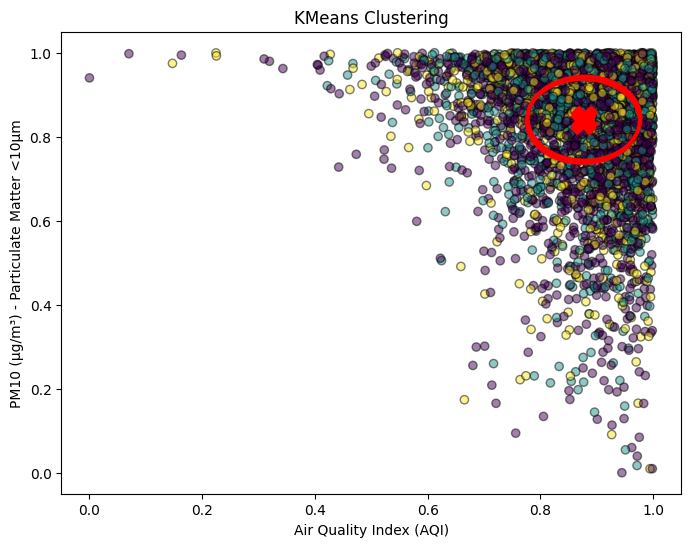

In [31]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

# Perform KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)  # You can change the number of clusters
kmeans.fit(X_clustering_imputed)

# Add the cluster labels to the dataframe
df['Cluster'] = kmeans.labels_

# Print the cluster centers
print("Cluster Centers:\n", kmeans.cluster_centers_)

# Plot the clusters
plt.figure(figsize=(8, 6))
plt.scatter(X_clustering_imputed[:, 0], X_clustering_imputed[:, 1], c=kmeans.labels_, cmap='viridis', edgecolor='k', alpha=0.5)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red', marker='X')

# Circle the clusters
for center in kmeans.cluster_centers_:
    circle = plt.Circle(center, 0.1, color='red', fill=False, linewidth=2)
    plt.gca().add_artist(circle)

plt.xlabel(X_clustering.columns[0])
plt.ylabel(X_clustering.columns[1])
plt.title('KMeans Clustering')
plt.show()

Agglomerative Clustering Labels:
 [0 1 0 ... 0 2 0]


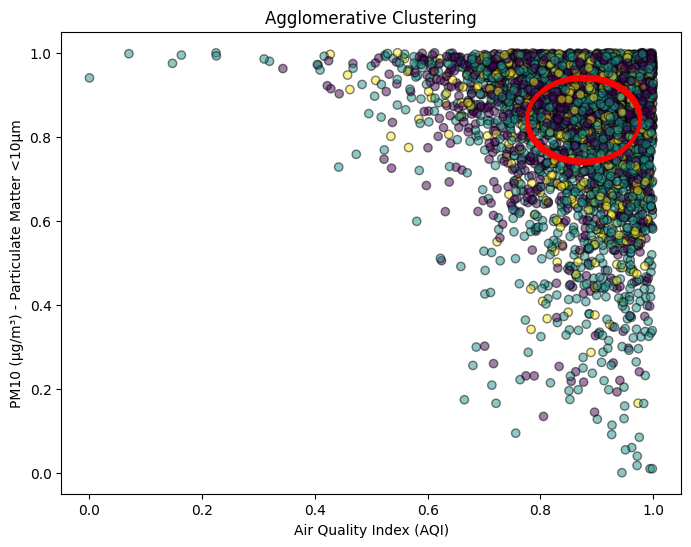

In [32]:
from sklearn.cluster import AgglomerativeClustering

# Perform Agglomerative Clustering
agg_clustering = AgglomerativeClustering(n_clusters=3)  # You can change the number of clusters
agg_clustering.fit(X_clustering_imputed)

# Add the cluster labels to the dataframe
df['Agg_Cluster'] = agg_clustering.labels_

# Print the cluster labels
print("Agglomerative Clustering Labels:\n", agg_clustering.labels_)

# Plot the clusters
plt.figure(figsize=(8, 6))
plt.scatter(X_clustering_imputed[:, 0], X_clustering_imputed[:, 1], c=agg_clustering.labels_, cmap='viridis', edgecolor='k', alpha=0.5)

# Circle the clusters
for center in kmeans.cluster_centers_:
    circle = plt.Circle(center, 0.1, color='red', fill=False, linewidth=2)
    plt.gca().add_artist(circle)

plt.xlabel(X_clustering.columns[0])
plt.ylabel(X_clustering.columns[1])
plt.title('Agglomerative Clustering')
plt.show()

DBSCAN Clustering Labels:
 [-1  0  0 ...  0  0  0]


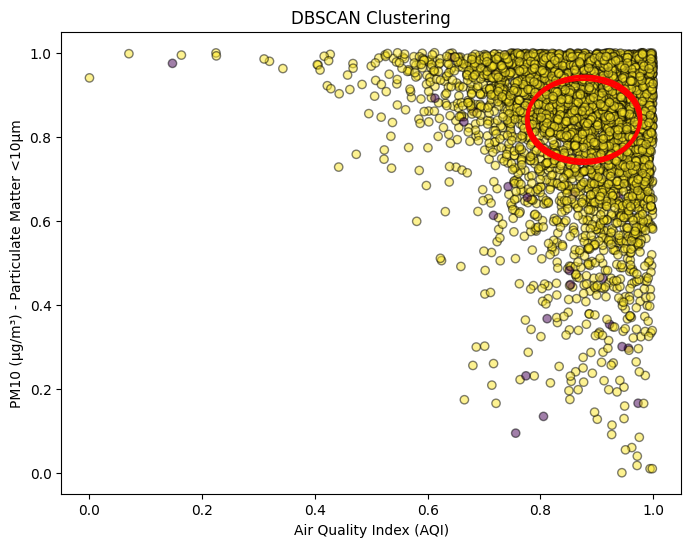

In [33]:
from sklearn.cluster import DBSCAN

# Perform DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)  # You can adjust the eps and min_samples parameters
dbscan.fit(X_clustering_imputed)

# Add the cluster labels to the dataframe
df['DBSCAN_Cluster'] = dbscan.labels_

# Print the cluster labels
print("DBSCAN Clustering Labels:\n", dbscan.labels_)

# Plot the clusters
plt.figure(figsize=(8, 6))
plt.scatter(X_clustering_imputed[:, 0], X_clustering_imputed[:, 1], c=dbscan.labels_, cmap='viridis', edgecolor='k', alpha=0.5)


# Circle the clusters
for center in kmeans.cluster_centers_:
    circle = plt.Circle(center, 0.1, color='red', fill=False, linewidth=2)
    plt.gca().add_artist(circle)

plt.xlabel(X_clustering.columns[0])
plt.ylabel(X_clustering.columns[1])
plt.title('DBSCAN Clustering')
plt.show()

In [34]:
# Load data from a CSV file
df = pd.read_csv('air_quality_5000.csv')  # Replace 'your_file.csv' with the actual file name

# Select features for clustering (e.g., PM2.5, PM10, NO2)
features = ['PM2.5', 'PM10', 'NO2', 'SO2', 'O3', 'CO']
X_clustering = df[features].values

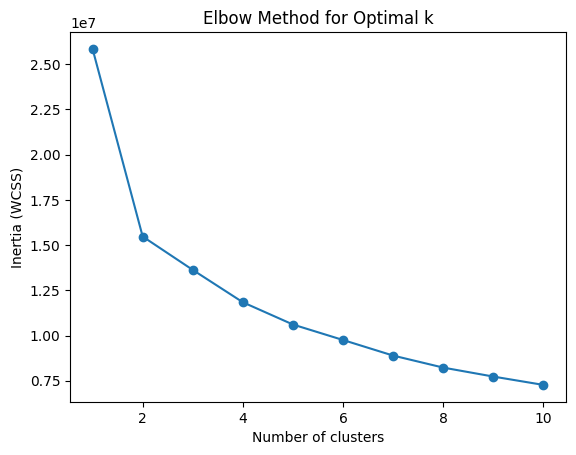

In [35]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Range of cluster numbers to try
range_of_clusters = range(1, 11)  # Try 1 to 10 clusters
inertia = []

# Calculate KMeans for each number of clusters
for k in range_of_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_clustering)
    inertia.append(kmeans.inertia_)  # WCSS

# Plotting the Elbow curve
plt.plot(range_of_clusters, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia (WCSS)')
plt.show()


C:\Users\bechi\AppData\Local\Temp\ipykernel_7972\585998425.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


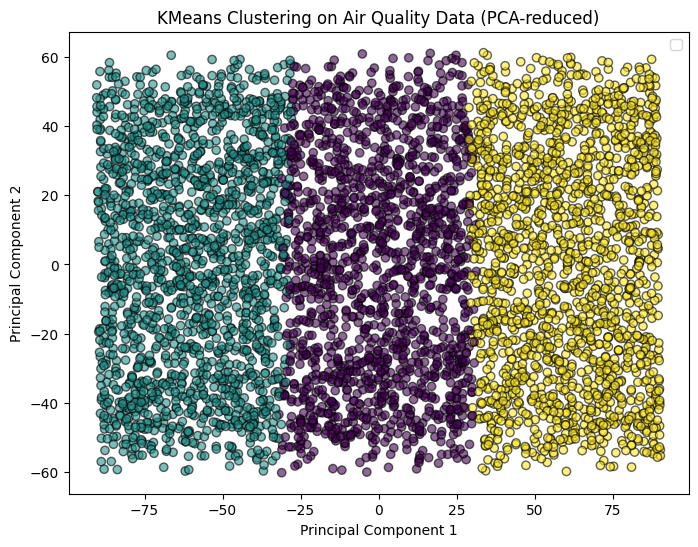

In [36]:


# Perform KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)  # You can adjust the number of clusters
kmeans.fit(X_clustering)

# Add cluster labels to the DataFrame
df['Cluster'] = kmeans.labels_



# Plot the clusters based on all features using PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_clustering)

plt.figure(figsize=(8, 6))
plt.scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=df['Cluster'], cmap='viridis', edgecolor='k', alpha=0.6
)

plt.title('KMeans Clustering on Air Quality Data (PCA-reduced)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


C:\Users\bechi\AppData\Local\Temp\ipykernel_7972\2445914603.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


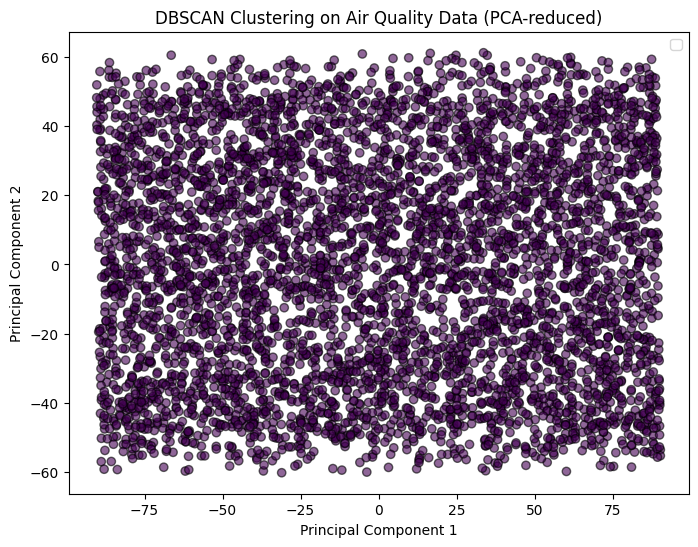

In [37]:
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Perform DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)  # You can adjust the epsilon (eps) and min_samples parameters
dbscan_labels = dbscan.fit_predict(X_clustering)

# Add DBSCAN cluster labels to the DataFrame
df['DBSCAN_Cluster'] = dbscan_labels

# Plot the clusters based on DBSCAN using PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_clustering)

plt.figure(figsize=(8, 6))
plt.scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=df['DBSCAN_Cluster'], cmap='viridis', edgecolor='k', alpha=0.6
)
plt.title('DBSCAN Clustering on Air Quality Data (PCA-reduced)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


C:\Users\bechi\AppData\Local\Temp\ipykernel_7972\1877809121.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


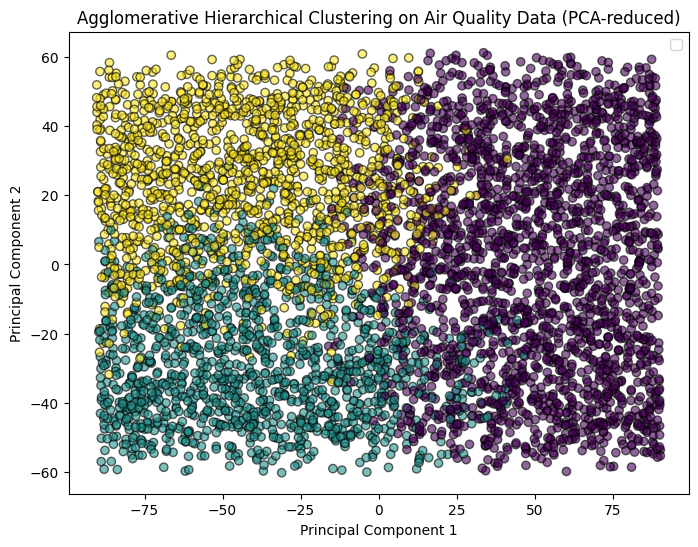

In [38]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Perform Agglomerative Hierarchical clustering
agg_clust = AgglomerativeClustering(n_clusters=3)  # You can adjust the number of clusters
agg_labels = agg_clust.fit_predict(X_clustering)

# Add Agglomerative cluster labels to the DataFrame
df['Agglomerative_Cluster'] = agg_labels

# Plot the clusters based on Agglomerative clustering using PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_clustering)

plt.figure(figsize=(8, 6))
plt.scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=df['Agglomerative_Cluster'], cmap='viridis', edgecolor='k', alpha=0.6
)
plt.title('Agglomerative Hierarchical Clustering on Air Quality Data (PCA-reduced)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


In [39]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

# KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(X_clustering)
kmeans_silhouette = silhouette_score(X_clustering, kmeans_labels)
print(f"KMeans Silhouette Score: {kmeans_silhouette}")

# DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_clustering)
# DBSCAN might assign -1 to noise points, so handle that when calculating the silhouette score
if len(set(dbscan_labels)) > 1:  # Ensure there are clusters to evaluate
    dbscan_silhouette = silhouette_score(X_clustering, dbscan_labels[dbscan_labels != -1])  # exclude noise
    print(f"DBSCAN Silhouette Score: {dbscan_silhouette}")
else:
    dbscan_silhouette = -1  # Assign a low score if DBSCAN found only one cluster or noise
    print("DBSCAN found only one cluster or noise, silhouette score cannot be calculated.")

# Agglomerative Clustering   (mahouch bech yekhdem ertehhh )
agg_clust = AgglomerativeClustering(n_clusters=3)
agg_labels = agg_clust.fit_predict(X_clustering)
agg_silhouette = silhouette_score(X_clustering, agg_labels)
print(f"Agglomerative Silhouette Score: {agg_silhouette}")

# Determine the best clustering algorithm
best_algorithm = max(
    [('KMeans', kmeans_silhouette), ('DBSCAN', dbscan_silhouette), ('Agglomerative', agg_silhouette)],
    key=lambda x: x[1]
)
print(f"Best Clustering Algorithm: {best_algorithm[0]} with Silhouette Score: {best_algorithm[1]}")


KMeans Silhouette Score: 0.20094294902852347
DBSCAN found only one cluster or noise, silhouette score cannot be calculated.
Agglomerative Silhouette Score: 0.22402839042644787
Best Clustering Algorithm: Agglomerative with Silhouette Score: 0.22402839042644787


profiling

In [40]:
from mlxtend.frequent_patterns import apriori, association_rules

df_binary = df.select_dtypes(include=[np.number]).applymap(lambda x: 1 if x > 0 else 0)

frequent_itemsets = apriori(df_binary, min_support=0.1, use_colnames=True)

rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0, num_itemsets=len(frequent_itemsets))

print(rules)

C:\Users\bechi\AppData\Local\Temp\ipykernel_7972\1434117036.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_binary = df.select_dtypes(include=[np.number]).applymap(lambda x: 1 if x > 0 else 0)
d:\ESPRIT\3AI\DataWarehouse\ML\New folder\.venv\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


      antecedents                                        consequents  \
0         (PM2.5)                                             (PM10)   
1          (PM10)                                            (PM2.5)   
2         (PM2.5)                                              (NO2)   
3           (NO2)                                            (PM2.5)   
4           (SO2)                                            (PM2.5)   
...           ...                                                ...   
94315        (CO)  (SO2, WindSpeed, NO2, Cluster, PM2.5, PM10, Te...   
94316     (PM2.5)  (SO2, WindSpeed, NO2, Cluster, CO, PM10, Tempe...   
94317      (PM10)  (SO2, WindSpeed, NO2, Cluster, CO, PM2.5, Temp...   
94318  (Humidity)  (SO2, WindSpeed, NO2, Cluster, CO, PM2.5, PM10...   
94319        (O3)  (SO2, WindSpeed, NO2, Cluster, CO, PM2.5, PM10...   

       antecedent support  consequent support  support  confidence  lift  \
0                     1.0               1.000    1.000     

d:\ESPRIT\3AI\DataWarehouse\ML\New folder\.venv\Lib\site-packages\mlxtend\frequent_patterns\association_rules.py:182: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)


In [41]:
from mlxtend.frequent_patterns import fpgrowth, association_rules

df_binary = df.select_dtypes(include=[np.number]).map(lambda x: 1 if x > 0 else 0)
frequent_itemsets_fp = fpgrowth(df_binary, min_support=0.1, use_colnames=True)

rules_fp = association_rules(frequent_itemsets_fp, metric="lift", min_threshold=0.5, num_itemsets=len(frequent_itemsets_fp))

print(rules_fp)



d:\ESPRIT\3AI\DataWarehouse\ML\New folder\.venv\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


                    antecedents  \
0                   (WindSpeed)   
1                          (CO)   
2                    (Humidity)   
3                          (CO)   
4                   (WindSpeed)   
...                         ...   
173047                   (PM10)   
173048            (Temperature)   
173049               (Humidity)   
173050                     (O3)   
173051  (Agglomerative_Cluster)   

                                              consequents  antecedent support  \
0                                                    (CO)              1.0000   
1                                             (WindSpeed)              1.0000   
2                                                    (CO)              1.0000   
3                                              (Humidity)              1.0000   
4                                              (Humidity)              1.0000   
...                                                   ...                 ...   
173047  (SO2

d:\ESPRIT\3AI\DataWarehouse\ML\New folder\.venv\Lib\site-packages\mlxtend\frequent_patterns\association_rules.py:182: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)


In [42]:
# Iterate through the first two rows of the rules dataframe
for i, row in rules_fp.head(2).iterrows():
    antecedent = ', '.join(row['antecedents'])  # Convert antecedents to a readable string
    consequent = ', '.join(row['consequents'])  # Convert consequents to a readable string
    support = row['support']
    confidence = row['confidence']
    lift = row['lift']
    print(f"Rule {i+1}: {{{antecedent}}} ??? {{{consequent}}}")
    print(f"  Support: {support:.4f}")
    print(f"  Confidence: {confidence:.4f}")
    print(f"  Lift: {lift:.4f}\n")


Rule 1: {WindSpeed} ??? {CO}
  Support: 1.0000
  Confidence: 1.0000
  Lift: 1.0000

Rule 2: {CO} ??? {WindSpeed}
  Support: 1.0000
  Confidence: 1.0000
  Lift: 1.0000



In [43]:
import time
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules

# 1. Measure Apriori Performance
start_time_apriori = time.time()
frequent_itemsets_apriori = apriori(df_binary, min_support=0.1, use_colnames=True)
execution_time_apriori = time.time() - start_time_apriori

rules_apriori = association_rules(frequent_itemsets_apriori, metric="lift", min_threshold=0.5,num_itemsets=len(frequent_itemsets_apriori))

# 2. Measure FP-Growth Performance
start_time_fpgrowth = time.time()
frequent_itemsets_fpgrowth = fpgrowth(df_binary, min_support=0.1, use_colnames=True)
execution_time_fpgrowth = time.time() - start_time_fpgrowth

rules_fpgrowth = association_rules(frequent_itemsets_fpgrowth, metric="lift", min_threshold=0.5,num_itemsets=len(frequent_itemsets_fp))

# 3. Print Results
print("=== Apriori Results ===")
print(f"Execution Time: {execution_time_apriori:.4f} seconds")
print(f"Number of Frequent Itemsets: {len(frequent_itemsets_apriori)}")
print(f"Number of Association Rules: {len(rules_apriori)}")

print("\n=== FP-Growth Results ===")
print(f"Execution Time: {execution_time_fpgrowth:.4f} seconds")
print(f"Number of Frequent Itemsets: {len(frequent_itemsets_fpgrowth)}")
print(f"Number of Association Rules: {len(rules_fpgrowth)}")

# 4. Determine the Better Algorithm
if execution_time_apriori < execution_time_fpgrowth:
    print("\nApriori is faster.")
else:
    print("\nFP-Growth is faster.")

if len(frequent_itemsets_apriori) > len(frequent_itemsets_fpgrowth):
    print("Apriori found more frequent itemsets.")
else:
    print("FP-Growth found more frequent itemsets.")


d:\ESPRIT\3AI\DataWarehouse\ML\New folder\.venv\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
d:\ESPRIT\3AI\DataWarehouse\ML\New folder\.venv\Lib\site-packages\mlxtend\frequent_patterns\association_rules.py:182: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)
d:\ESPRIT\3AI\DataWarehouse\ML\New folder\.venv\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


=== Apriori Results ===
Execution Time: 0.1715 seconds
Number of Frequent Itemsets: 2047
Number of Association Rules: 173052

=== FP-Growth Results ===
Execution Time: 20.0709 seconds
Number of Frequent Itemsets: 2047
Number of Association Rules: 173052

Apriori is faster.
FP-Growth found more frequent itemsets.


d:\ESPRIT\3AI\DataWarehouse\ML\New folder\.venv\Lib\site-packages\mlxtend\frequent_patterns\association_rules.py:182: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)


Performance Summary

    Execution Time:

        Apriori is significantly faster (0.17 seconds) than FP-Growth (20.76 seconds).
        This suggests that Apriori is more efficient for my dataset.

    Frequent Itemsets:

        Both algorithms found the same number of frequent itemsets (2047), meaning the results are identical in terms of frequent patterns discovered.

    Association Rules:

        Both algorithms generated the same number of rules (173,052), showing their output quality is equivalent.

Conclusion
Apriori is the better choice for my dataset.
It provides the same results as FP-Growth but executes ~122x faster.
FP-Growth's advantage of speed typically applies to larger datasets, but in this case, it appears to have overhead due to how it processes the data.